## Importing Libraries



In [ ]:
import numpy as np
import pandas as pd
import pickle

np.random.seed(42)

## GBOOST TREE NODES    
---

> This class defines a node which creates a tree structure by recursively calling itself whilst checking a number of ending parameters such as depth and min_leaf.
It uses an exact greedy method to exhaustively scan every possible split point.
Algorithm is based on Frieman's 2001 Gradient Boosting Machines.


<br>

### Class Functions:
---

**find_varsplit:**

        Scans through every column and calcuates the best split point.
        The node is then split at this point and two new nodes are created.
        Depth is only parameter to change as we have added a new layer to tree structure.
        If no split is better than the score initalised at the beginning then no splits further splits are made.

---
**find_greedy_split:**


        For a given feature calculates the gain at each split.
        Globally updates the best score if a better split point is found.

---
**gain:**

        Computes the gain for a specific split point based on Frieman's 2001 Gradient Boosting Machines

---
**compute_gamma:**

        This is the optimal leaf node value from Frieman's 2001 Gradient Boosting Machines for a GBM classifier.

---
### Inputs:



> X: Pandas dataframe <br>
  y: Pandas Series <br>
  idxs: indices of values used to keep track of splits points in tree <br>
  min_leaf: minimum number of samples needed to be classified as a node <br>
  depth: sets the maximum depth allowed.

---
### Output:

> Regression tree that can be used in gradient booting for regression.

In [ ]:
class Node:
    def __init__(self, x, y, idxs, min_leaf=5, depth = 10):

        self.x, self.y = x, y
        self.idxs = idxs
        self.depth = depth
        self.min_leaf = min_leaf
        self.row_count = len(idxs)
        self.col_count = x.shape[1]
        self.val = self.compute_gamma(y[self.idxs])
        self.score = float('-inf')
        self.find_varsplit()

    def find_varsplit(self):
        for c in range(self.col_count): self.find_greedy_split(c)
        if self.is_leaf: return
        x = self.split_col

        lhs = np.nonzero(x <= self.split)[0]
        rhs = np.nonzero(x > self.split)[0]
        self.lhs = Node(self.x, self.y, self.idxs[lhs], self.min_leaf, depth = self.depth-1)
        self.rhs = Node(self.x, self.y, self.idxs[rhs], self.min_leaf, depth = self.depth-1)

    def find_greedy_split(self, var_idx):

        x = self.x.values[self.idxs, var_idx]

        for r in range(self.row_count):
            lhs = x <= x[r]
            rhs = x > x[r]

            if(rhs.sum() < self.min_leaf or lhs.sum() < self.min_leaf):continue
            curr_score = self.gain(lhs, rhs)
            if curr_score > self.score:
                self.var_idx = var_idx
                self.score = curr_score
                self.split = x[r]


    def gain(self, lhs, rhs):

        gradient = self.y[self.idxs]

        lhs_gradient = gradient[lhs].sum()
        lhs_n_intances = len(gradient[lhs])
        rhs_gradient = gradient[rhs].sum()
        rhs_n_intances = len(gradient[rhs])

        gain = ((lhs_gradient**2/(lhs_n_intances)) + (rhs_gradient**2/(rhs_n_intances))
                - ((lhs_gradient + rhs_gradient)**2/(lhs_n_intances + rhs_n_intances)))
        return(gain)

    @staticmethod
    def compute_gamma(gradient):
        return(np.sum(gradient)/len(gradient))

    @property
    def split_col(self):
        return self.x.values[self.idxs, self.var_idx]

    @property
    def is_leaf(self):
        return self.score == float('-inf') or self.depth <= 0

    def predict(self, x):
        return np.array([self.predict_row(xi) for xi in x])

    def predict_row(self, xi):
        if self.is_leaf: return self.val
        node = self.lhs if xi[self.var_idx] <= self.split else self.rhs
        return node.predict_row(xi)

## DECISION TREE REGRESSOR
---

> This class is a Wrapper class that provides a scikit learn interface to the recursive regression tree above. It provides methods to fit and predict datapoints for a single decision tree.

### Inputs:



> X: Pandas dataframe <br>
      y: Pandas Series <br>
      min_leaf: minimum number of samples needed to be classified as a node <br>
      depth: sets the maximum depth allowed

---
### Output:

>  A regression tree which has all weights learnt.

In [ ]:
class DecisionTreeRegressor:

    def fit(self, X, y, min_leaf = 5, depth = 5):
        self.dtree = Node(X, y, np.array(np.arange(len(y))), min_leaf, depth)
        return self

    def predict(self, X):
        return self.dtree.predict(X.values)

## GRADIENT BOOSTING REGRESSOR
---

> This class applies the methodology of gradeint boosting machines Friedman 2001 for regression. It uses the mean squared loss function to calculate the negative derivate.

### Inputs:



> X: Pandas dataframe <br>
      y: Pandas Series <br>
      min_leaf: minimum number of samples needed to be classified as a node <br>
      depth: sets the maximum depth allowed <br>
      Boosting_Rounds: number of boosting rounds or iterations

---
### Output:

>  Gradient boosting machine that can be used for regression.

In [ ]:
class GradientBoostingRegressor:
    def __init__(self, classification = False):
        self.estimators = []

    @staticmethod
    def MeanSquaredError(y, y_pred):
        return(np.mean((y - y_pred)**2))

    @staticmethod
    def negativeMeanSquaredErrorDerivitive(y, y_pred):
        return(2*(y-y_pred))

    def fit(self, X, y, depth = 5, min_leaf = 5, learning_rate = 0.1, boosting_rounds = 5):

        # Start with the mean y value as our initial prediciton
        self.learning_rate = learning_rate
        self.base_pred = np.full((X.shape[0], 1), np.mean(y)).flatten()

        for booster in range(boosting_rounds):
            # Calculate the initial Pseudo Residuals using Base Prediction.
            pseudo_residuals = self.negativeMeanSquaredErrorDerivitive(y, self.base_pred)
            boosting_tree = DecisionTreeRegressor().fit(X = X, y = pseudo_residuals, depth = 5, min_leaf = 5)
            self.base_pred += self.learning_rate * boosting_tree.predict(X)
            self.estimators.append(boosting_tree)
            print("Boosting round",booster+1,"/",boosting_rounds,"completed.")
            print("TRAINING LOSS: ",self.MeanSquaredError(y,self.base_pred),end = "\t")
            print("TESTING LOSS: ",self.MeanSquaredError(test_df['PJME_MW'] , self.predict(test_df.drop(columns = ['PJME_MW']))  ))


    def predict(self, X):

        pred = np.zeros(X.shape[0])
        for estimator in self.estimators:
            pred += self.learning_rate * estimator.predict(X)

        return np.full((X.shape[0], 1), np.mean(y)).flatten() + pred

## Loading the dataframe

In [ ]:
with open('dataframe.pickle', 'rb') as f:
    df = pickle.load(f)

df.head()

,Datetime,PJME_MW,Lag1,Lag2,Hour_sin,Hour_cos,Day_sin,Day_cos
0,2004-12-31 01:00:00,27160.0,27077.0,25591.0,0.258819,0.965926,-2.449294e-16,1.0
1,2004-12-31 02:00:00,25791.0,25957.0,24235.0,0.500000,0.866025,-2.449294e-16,1.0
2,2004-12-31 03:00:00,25052.0,24930.0,23121.0,0.707107,0.707107,-2.449294e-16,1.0
3,2004-12-31 04:00:00,24797.0,24359.0,22445.0,0.866025,0.500000,-2.449294e-16,1.0
4,2004-12-31 05:00:00,25026.0,24400.0,22332.0,0.965926,0.258819,-2.449294e-16,1.0


### Preprocessing

In [ ]:
num_rows = df.shape[0]
df=df[:30000]

# 80-20 split
train_df = df.sample(frac=0.8, random_state=42)
test_df = df.drop(train_df.index)

train_df=train_df.drop(columns=['Datetime'])
test_df=test_df.drop(columns=['Datetime'])

In [ ]:
print("Training dataframe shape: ",train_df.shape)
print("Testing dataframe shape: ",test_df.shape)

Training dataframe shape:  (24000, 7)
Testing dataframe shape:  (6000, 7)


In [ ]:
train_df.head()

,PJME_MW,Lag1,Lag2,Hour_sin,Hour_cos,Day_sin,Day_cos
2308,23320.0,26219.0,30018.0,0.866025,-0.500000,-0.997018,-0.077175
22404,20758.0,28672.0,26025.0,0.866025,0.500000,0.352752,-0.935717
23397,31482.0,26420.0,29373.0,-0.258819,-0.965926,0.874481,-0.485060
25058,38100.0,36494.0,33766.0,-0.707107,0.707107,0.778764,0.627317
2664,23902.0,23292.0,22525.0,0.866025,0.500000,-0.944489,-0.328542


## Training

In [ ]:
# Initialize the model
model = GradientBoostingRegressor()
train_df=train_df.reset_index(drop=True)

# Fit the model
X=train_df.drop(columns = ['PJME_MW'])
y=train_df['PJME_MW']

model.fit(X,y , depth=5, min_leaf=5, learning_rate=0.2, boosting_rounds=5)

Boosting round 1 / 5 completed.
TRAINING LOSS:  25459379.035853088	TESTING LOSS:  26131710.09152379
Boosting round 2 / 5 completed.
TRAINING LOSS:  18592811.850827422	TESTING LOSS:  19285823.076212913
Boosting round 3 / 5 completed.
TRAINING LOSS:  15475860.809540879	TESTING LOSS:  16241288.50739456
Boosting round 4 / 5 completed.
TRAINING LOSS:  13944934.441656835	TESTING LOSS:  14754258.032606695
Boosting round 5 / 5 completed.
TRAINING LOSS:  12783220.965174891	TESTING LOSS:  13538484.768594513


# Making Predictions

In [ ]:
predictions = model.predict(test_df.drop(columns = ['PJME_MW']))

In [ ]:
Actual_Values = np.array(test_df['PJME_MW'])
Predicted_Values = predictions
pd.DataFrame({'Actual Values':Actual_Values, 'Predicted Values':Predicted_Values})

,Actual Values,Predicted Values
0,31238.0,31924.517237
1,31225.0,31374.045367
2,29665.0,31788.021235
3,30679.0,31896.302967
4,27675.0,28622.522118
...,...,...
5995,45292.0,46708.560343
5996,37199.0,41728.232553
5997,38171.0,34052.361443
5998,48661.0,48305.904805


In [ ]:
print('MSE: '+str(model.MeanSquaredError(Actual_Values,Predicted_Values)))
print('RMSE: '+str(model.MeanSquaredError(Actual_Values,Predicted_Values)**0.5))

MSE: 13538484.768594513
RMSE: 3679.4680007569727


In [ ]:
predictions = model.predict(df.drop(columns = ['PJME_MW','Datetime']))
Actual_Values = np.array(df['PJME_MW'])
Predicted_Values = predictions
pd.DataFrame({'Actual Values':Actual_Values, 'Predicted Values':Predicted_Values})

,Actual Values,Predicted Values
0,27160.0,27986.370970
1,25791.0,26365.262433
2,25052.0,26213.100760
3,24797.0,26213.100760
4,25026.0,26213.100760
...,...,...
29995,48867.0,48305.904805
29996,48661.0,48305.904805
29997,47424.0,47565.498623
29998,45847.0,46983.407188


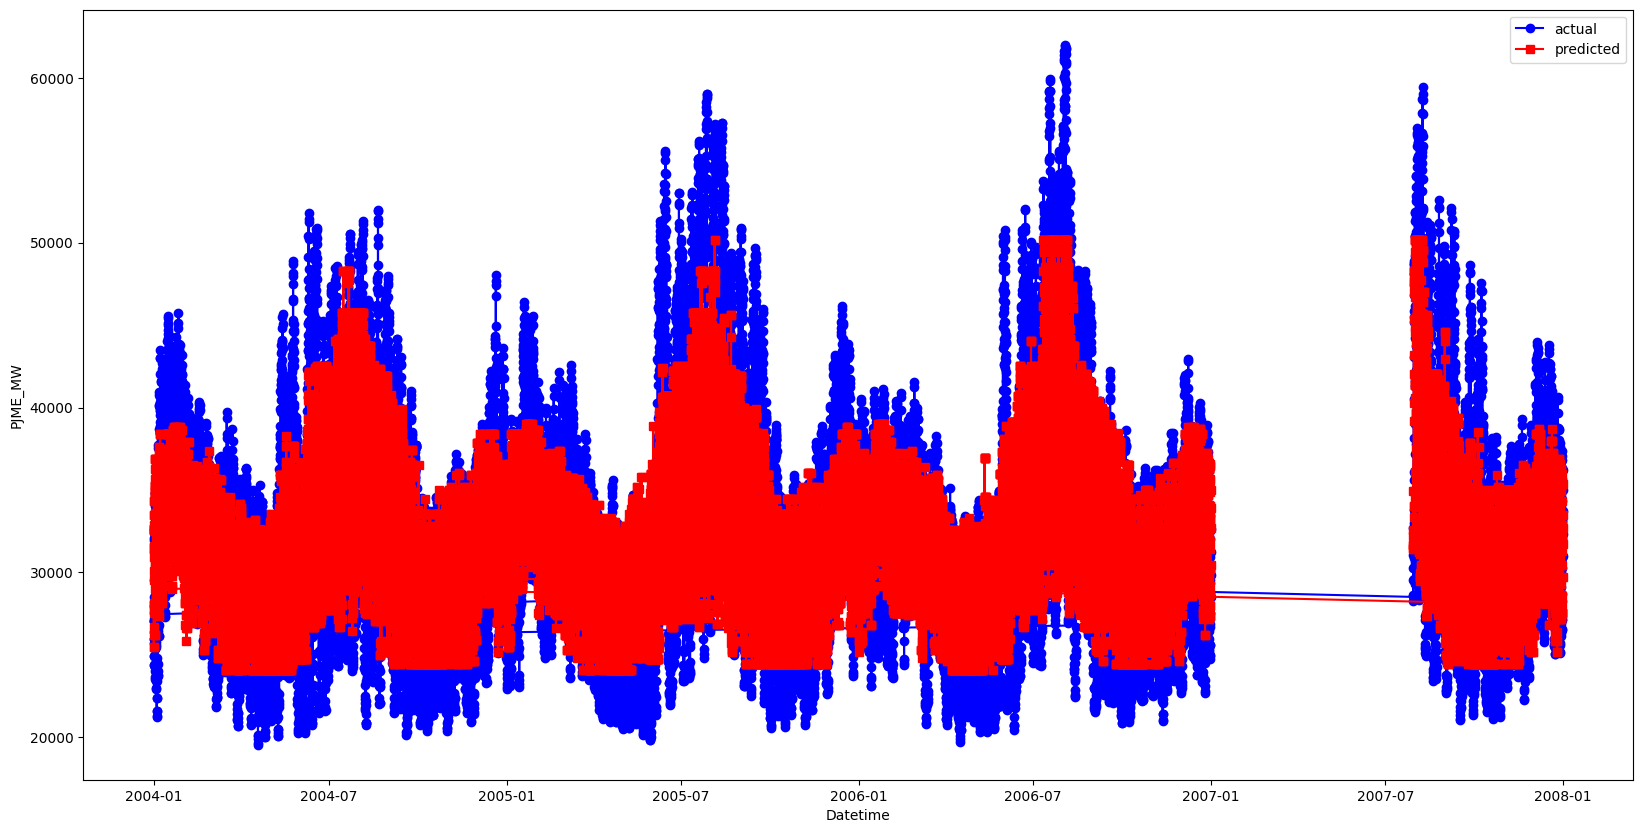

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(df['Datetime'], Actual_Values, label='actual',color='blue', marker='o')

plt.plot(df['Datetime'], Predicted_Values, label='predicted',color='red', marker='s')

plt.xlabel('Datetime')
plt.ylabel('PJME_MW')

plt.legend()
plt.show()

Library Method

In [66]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import pickle

In [71]:
with open('dataframe.pickle', 'rb') as f:
    df = pickle.load(f)

In [68]:
# df=df[df.isna().sum(axis=1)==0]    #dropping null data frames

# mean=df.mean()
# std=df.std()
# df=(df-mean)/std  # Normalization

df=df[:30000]
df=df.drop(columns=['Datetime'])

X=df.drop(columns = ['PJME_MW'])
y=df['PJME_MW']

In [69]:

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Gradient Boosting Regressor
gb_regressor = GradientBoostingRegressor(n_estimators=5, learning_rate=0.2, max_depth=5, random_state=42)

# Train the model
gb_regressor.fit(X_train, y_train)

# Make predictions on the test set
y_pred = gb_regressor.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
print("Mean Squared Error:", (mse)**0.5)

Mean Squared Error: 17709380.176207043
Mean Squared Error: 4208.251439280576
